In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                       | 0/60000 [00:00<?, ?it/s]

 12%|██████████▉                                                                              | 7340/60000 [00:00<00:00, 73397.27it/s]

 24%|█████████████████████▌                                                                  | 14680/60000 [00:00<00:00, 73225.36it/s]

 37%|████████████████████████████████▎                                                       | 22003/60000 [00:00<00:00, 72464.53it/s]

 49%|███████████████████████████████████████████▏                                            | 29425/60000 [00:00<00:00, 73151.37it/s]

 61%|██████████████████████████████████████████████████████                                  | 36850/60000 [00:00<00:00, 73543.36it/s]

 74%|████████████████████████████████████████████████████████████████▊                       | 44206/60000 [00:00<00:00, 71164.18it/s]

 86%|███████████████████████████████████████████████████████████████████████████▋            | 51641/60000 [00:00<00:00, 72177.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████▎ | 58871/60000 [00:00<00:00, 67572.44it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 70410.14it/s]

  0%|                                                                                                       | 0/10000 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████▉                                    | 5951/10000 [00:00<00:00, 59502.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 59333.35it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 mf83m6il


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                         | 0/368 [00:00<?, ?it/s]

  0%|▎                                                                                                | 1/368 [00:00<05:23,  1.13it/s]

  1%|█▎                                                                                               | 5/368 [00:01<00:57,  6.34it/s]

  2%|██▎                                                                                              | 9/368 [00:01<00:31, 11.48it/s]

  4%|███▍                                                                                            | 13/368 [00:01<00:21, 16.34it/s]

  5%|████▍                                                                                           | 17/368 [00:01<00:17, 20.61it/s]

  6%|█████▍                                                                                          | 21/368 [00:01<00:14, 24.16it/s]

  7%|██████▌                                                                                         | 25/368 [00:01<00:12, 27.04it/s]

  8%|███████▌                                                                                        | 29/368 [00:01<00:11, 29.24it/s]

  9%|████████▌                                                                                       | 33/368 [00:01<00:10, 30.88it/s]

 10%|█████████▋                                                                                      | 37/368 [00:01<00:10, 32.11it/s]

 11%|██████████▋                                                                                     | 41/368 [00:02<00:09, 32.99it/s]

 12%|███████████▋                                                                                    | 45/368 [00:02<00:09, 33.50it/s]

 13%|████████████▊                                                                                   | 49/368 [00:02<00:09, 33.91it/s]

 14%|█████████████▊                                                                                  | 53/368 [00:02<00:09, 34.15it/s]

 15%|██████████████▊                                                                                 | 57/368 [00:02<00:09, 34.34it/s]

 17%|███████████████▉                                                                                | 61/368 [00:02<00:08, 34.48it/s]

 18%|████████████████▉                                                                               | 65/368 [00:02<00:08, 34.59it/s]

 19%|██████████████████                                                                              | 69/368 [00:02<00:08, 34.73it/s]

 20%|███████████████████                                                                             | 73/368 [00:02<00:08, 34.80it/s]

 21%|████████████████████                                                                            | 77/368 [00:03<00:08, 34.67it/s]

 22%|█████████████████████▏                                                                          | 81/368 [00:03<00:08, 34.68it/s]

 23%|██████████████████████▏                                                                         | 85/368 [00:03<00:08, 34.74it/s]

 24%|███████████████████████▏                                                                        | 89/368 [00:03<00:08, 34.65it/s]

 25%|████████████████████████▎                                                                       | 93/368 [00:03<00:07, 34.68it/s]

 26%|█████████████████████████▎                                                                      | 97/368 [00:03<00:07, 34.67it/s]

 27%|██████████████████████████                                                                     | 101/368 [00:03<00:07, 34.71it/s]

 29%|███████████████████████████                                                                    | 105/368 [00:03<00:07, 34.75it/s]

 30%|████████████████████████████▏                                                                  | 109/368 [00:03<00:07, 34.80it/s]

 31%|█████████████████████████████▏                                                                 | 113/368 [00:04<00:07, 34.88it/s]

 32%|██████████████████████████████▏                                                                | 117/368 [00:04<00:07, 34.86it/s]

 33%|███████████████████████████████▏                                                               | 121/368 [00:04<00:07, 34.89it/s]

 34%|████████████████████████████████▎                                                              | 125/368 [00:04<00:06, 35.03it/s]

 35%|█████████████████████████████████▎                                                             | 129/368 [00:04<00:06, 35.17it/s]

 36%|██████████████████████████████████▎                                                            | 133/368 [00:04<00:06, 35.30it/s]

 37%|███████████████████████████████████▎                                                           | 137/368 [00:04<00:06, 35.29it/s]

 38%|████████████████████████████████████▍                                                          | 141/368 [00:04<00:06, 35.30it/s]

 39%|█████████████████████████████████████▍                                                         | 145/368 [00:05<00:06, 35.36it/s]

 40%|██████████████████████████████████████▍                                                        | 149/368 [00:05<00:06, 35.38it/s]

 42%|███████████████████████████████████████▍                                                       | 153/368 [00:05<00:06, 35.46it/s]

 43%|████████████████████████████████████████▌                                                      | 157/368 [00:05<00:05, 35.42it/s]

 44%|█████████████████████████████████████████▌                                                     | 161/368 [00:05<00:05, 35.41it/s]

 45%|██████████████████████████████████████████▌                                                    | 165/368 [00:05<00:05, 35.39it/s]

 46%|███████████████████████████████████████████▋                                                   | 169/368 [00:05<00:05, 35.37it/s]

 47%|████████████████████████████████████████████▋                                                  | 173/368 [00:05<00:05, 35.41it/s]

 48%|█████████████████████████████████████████████▋                                                 | 177/368 [00:05<00:05, 35.39it/s]

 49%|██████████████████████████████████████████████▋                                                | 181/368 [00:06<00:05, 35.31it/s]

 50%|███████████████████████████████████████████████▊                                               | 185/368 [00:06<00:05, 35.01it/s]

 51%|████████████████████████████████████████████████▊                                              | 189/368 [00:06<00:05, 35.06it/s]

 52%|█████████████████████████████████████████████████▊                                             | 193/368 [00:06<00:04, 35.11it/s]

 54%|██████████████████████████████████████████████████▊                                            | 197/368 [00:06<00:04, 35.07it/s]

 55%|███████████████████████████████████████████████████▉                                           | 201/368 [00:06<00:04, 34.92it/s]

 56%|████████████████████████████████████████████████████▉                                          | 205/368 [00:06<00:04, 34.95it/s]

 57%|█████████████████████████████████████████████████████▉                                         | 209/368 [00:06<00:04, 34.96it/s]

 58%|██████████████████████████████████████████████████████▉                                        | 213/368 [00:06<00:04, 35.00it/s]

 59%|████████████████████████████████████████████████████████                                       | 217/368 [00:07<00:04, 34.94it/s]

 60%|█████████████████████████████████████████████████████████                                      | 221/368 [00:07<00:04, 34.91it/s]

 61%|██████████████████████████████████████████████████████████                                     | 225/368 [00:07<00:04, 34.80it/s]

 62%|███████████████████████████████████████████████████████████                                    | 229/368 [00:07<00:04, 34.68it/s]

 63%|████████████████████████████████████████████████████████████▏                                  | 233/368 [00:07<00:03, 34.58it/s]

 64%|█████████████████████████████████████████████████████████████▏                                 | 237/368 [00:07<00:03, 34.49it/s]

 65%|██████████████████████████████████████████████████████████████▏                                | 241/368 [00:07<00:03, 34.46it/s]

 67%|███████████████████████████████████████████████████████████████▏                               | 245/368 [00:07<00:03, 34.16it/s]

 68%|████████████████████████████████████████████████████████████████▎                              | 249/368 [00:07<00:03, 34.13it/s]

 69%|█████████████████████████████████████████████████████████████████▎                             | 253/368 [00:08<00:03, 34.18it/s]

 70%|██████████████████████████████████████████████████████████████████▎                            | 257/368 [00:08<00:03, 34.25it/s]

 71%|███████████████████████████████████████████████████████████████████▍                           | 261/368 [00:08<00:03, 34.23it/s]

 72%|████████████████████████████████████████████████████████████████████▍                          | 265/368 [00:08<00:03, 34.09it/s]

 73%|█████████████████████████████████████████████████████████████████████▍                         | 269/368 [00:08<00:02, 34.17it/s]

 74%|██████████████████████████████████████████████████████████████████████▍                        | 273/368 [00:08<00:02, 34.29it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                       | 277/368 [00:08<00:02, 34.46it/s]

 76%|████████████████████████████████████████████████████████████████████████▌                      | 281/368 [00:08<00:02, 34.60it/s]

 77%|█████████████████████████████████████████████████████████████████████████▌                     | 285/368 [00:09<00:02, 34.63it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                    | 289/368 [00:09<00:02, 34.71it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                   | 293/368 [00:09<00:02, 34.73it/s]

 81%|████████████████████████████████████████████████████████████████████████████▋                  | 297/368 [00:09<00:02, 34.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 301/368 [00:09<00:01, 34.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▋                | 305/368 [00:09<00:01, 34.92it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▊               | 309/368 [00:09<00:01, 34.97it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▊              | 313/368 [00:09<00:01, 34.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 317/368 [00:09<00:01, 34.88it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 321/368 [00:10<00:01, 34.87it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 325/368 [00:10<00:01, 34.83it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 329/368 [00:10<00:01, 34.74it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 333/368 [00:10<00:01, 34.43it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 337/368 [00:10<00:00, 34.19it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████       | 341/368 [00:10<00:00, 34.17it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 345/368 [00:10<00:00, 34.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 349/368 [00:10<00:00, 33.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 353/368 [00:11<00:00, 34.12it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 357/368 [00:11<00:00, 34.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 361/368 [00:11<00:00, 34.40it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 365/368 [00:11<00:00, 34.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:11<00:00, 32.06it/s]

train - OK


  0%|                                                                                                          | 0/92 [00:00<?, ?it/s]

  1%|█                                                                                                 | 1/92 [00:00<00:09,  9.17it/s]

  5%|█████▎                                                                                            | 5/92 [00:00<00:03, 23.86it/s]

 10%|█████████▌                                                                                        | 9/92 [00:00<00:02, 28.54it/s]

 14%|█████████████▋                                                                                   | 13/92 [00:00<00:02, 30.71it/s]

 18%|█████████████████▉                                                                               | 17/92 [00:00<00:02, 31.80it/s]

 23%|██████████████████████▏                                                                          | 21/92 [00:00<00:02, 32.20it/s]

 27%|██████████████████████████▎                                                                      | 25/92 [00:00<00:02, 32.75it/s]

 32%|██████████████████████████████▌                                                                  | 29/92 [00:00<00:01, 33.05it/s]

 36%|██████████████████████████████████▊                                                              | 33/92 [00:01<00:01, 33.38it/s]

 40%|███████████████████████████████████████                                                          | 37/92 [00:01<00:01, 33.55it/s]

 45%|███████████████████████████████████████████▏                                                     | 41/92 [00:01<00:01, 33.58it/s]

 49%|███████████████████████████████████████████████▍                                                 | 45/92 [00:01<00:01, 33.56it/s]

 53%|███████████████████████████████████████████████████▋                                             | 49/92 [00:01<00:01, 33.52it/s]

 58%|███████████████████████████████████████████████████████▉                                         | 53/92 [00:01<00:01, 33.53it/s]

 62%|████████████████████████████████████████████████████████████                                     | 57/92 [00:01<00:01, 33.49it/s]

 66%|████████████████████████████████████████████████████████████████▎                                | 61/92 [00:01<00:00, 33.49it/s]

 71%|████████████████████████████████████████████████████████████████████▌                            | 65/92 [00:02<00:00, 33.51it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 69/92 [00:02<00:00, 33.83it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 73/92 [00:02<00:00, 34.05it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 77/92 [00:02<00:00, 34.12it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 81/92 [00:02<00:00, 34.25it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 85/92 [00:02<00:00, 34.39it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 89/92 [00:02<00:00, 34.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:02<00:00, 32.30it/s]

val - OK


  0%|                                                                                                          | 0/76 [00:00<?, ?it/s]

  1%|█▎                                                                                                | 1/76 [00:00<00:07,  9.44it/s]

  7%|██████▍                                                                                           | 5/76 [00:00<00:02, 24.56it/s]

 12%|███████████▌                                                                                      | 9/76 [00:00<00:02, 29.31it/s]

 17%|████████████████▌                                                                                | 13/76 [00:00<00:02, 31.49it/s]

 22%|█████████████████████▋                                                                           | 17/76 [00:00<00:01, 32.67it/s]

 28%|██████████████████████████▊                                                                      | 21/76 [00:00<00:01, 33.44it/s]

 33%|███████████████████████████████▉                                                                 | 25/76 [00:00<00:01, 33.95it/s]

 38%|█████████████████████████████████████                                                            | 29/76 [00:00<00:01, 34.25it/s]

 43%|██████████████████████████████████████████                                                       | 33/76 [00:01<00:01, 34.23it/s]

 49%|███████████████████████████████████████████████▏                                                 | 37/76 [00:01<00:01, 34.44it/s]

 54%|████████████████████████████████████████████████████▎                                            | 41/76 [00:01<00:01, 34.57it/s]

 59%|█████████████████████████████████████████████████████████▍                                       | 45/76 [00:01<00:00, 34.66it/s]

 64%|██████████████████████████████████████████████████████████████▌                                  | 49/76 [00:01<00:00, 34.72it/s]

 70%|███████████████████████████████████████████████████████████████████▋                             | 53/76 [00:01<00:00, 34.72it/s]

 75%|████████████████████████████████████████████████████████████████████████▊                        | 57/76 [00:01<00:00, 34.77it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 61/76 [00:01<00:00, 34.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 65/76 [00:01<00:00, 34.68it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████         | 69/76 [00:02<00:00, 34.80it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 73/76 [00:02<00:00, 34.95it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:02<00:00, 32.80it/s]

test InD - OK


  0%|                                                                                                         | 0/559 [00:00<?, ?it/s]

  0%|▏                                                                                                | 1/559 [00:00<01:01,  9.11it/s]

  1%|▊                                                                                                | 5/559 [00:00<00:23, 24.08it/s]

  2%|█▌                                                                                               | 9/559 [00:00<00:19, 28.91it/s]

  2%|██▏                                                                                             | 13/559 [00:00<00:17, 31.19it/s]

  3%|██▉                                                                                             | 17/559 [00:00<00:16, 32.39it/s]

  4%|███▌                                                                                            | 21/559 [00:00<00:16, 33.10it/s]

  4%|████▎                                                                                           | 25/559 [00:00<00:15, 33.56it/s]

  5%|████▉                                                                                           | 29/559 [00:00<00:15, 33.83it/s]

  6%|█████▋                                                                                          | 33/559 [00:01<00:15, 33.97it/s]

  7%|██████▎                                                                                         | 37/559 [00:01<00:15, 34.10it/s]

  7%|███████                                                                                         | 41/559 [00:01<00:15, 33.91it/s]

  8%|███████▋                                                                                        | 45/559 [00:01<00:15, 34.02it/s]

  9%|████████▍                                                                                       | 49/559 [00:01<00:14, 34.04it/s]

  9%|█████████                                                                                       | 53/559 [00:01<00:14, 34.09it/s]

 10%|█████████▊                                                                                      | 57/559 [00:01<00:14, 34.18it/s]

 11%|██████████▍                                                                                     | 61/559 [00:01<00:14, 34.18it/s]

 12%|███████████▏                                                                                    | 65/559 [00:01<00:14, 34.22it/s]

 12%|███████████▊                                                                                    | 69/559 [00:02<00:14, 34.22it/s]

 13%|████████████▌                                                                                   | 73/559 [00:02<00:14, 34.24it/s]

 14%|█████████████▏                                                                                  | 77/559 [00:02<00:14, 34.27it/s]

 14%|█████████████▉                                                                                  | 81/559 [00:02<00:13, 34.25it/s]

 15%|██████████████▌                                                                                 | 85/559 [00:02<00:13, 34.21it/s]

 16%|███████████████▎                                                                                | 89/559 [00:02<00:13, 34.09it/s]

 17%|███████████████▉                                                                                | 93/559 [00:02<00:13, 34.12it/s]

 17%|████████████████▋                                                                               | 97/559 [00:02<00:13, 33.97it/s]

 18%|█████████████████▏                                                                             | 101/559 [00:03<00:13, 33.92it/s]

 19%|█████████████████▊                                                                             | 105/559 [00:03<00:13, 33.96it/s]

 19%|██████████████████▌                                                                            | 109/559 [00:03<00:13, 33.90it/s]

 20%|███████████████████▏                                                                           | 113/559 [00:03<00:13, 33.75it/s]

 21%|███████████████████▉                                                                           | 117/559 [00:03<00:13, 33.66it/s]

 22%|████████████████████▌                                                                          | 121/559 [00:03<00:13, 33.67it/s]

 22%|█████████████████████▏                                                                         | 125/559 [00:03<00:12, 33.67it/s]

 23%|█████████████████████▉                                                                         | 129/559 [00:03<00:12, 33.80it/s]

 24%|██████████████████████▌                                                                        | 133/559 [00:03<00:12, 33.92it/s]

 25%|███████████████████████▎                                                                       | 137/559 [00:04<00:12, 33.99it/s]

 25%|███████████████████████▉                                                                       | 141/559 [00:04<00:12, 34.01it/s]

 26%|████████████████████████▋                                                                      | 145/559 [00:04<00:12, 33.84it/s]

 27%|█████████████████████████▎                                                                     | 149/559 [00:04<00:12, 33.77it/s]

 27%|██████████████████████████                                                                     | 153/559 [00:04<00:12, 33.63it/s]

 28%|██████████████████████████▋                                                                    | 157/559 [00:04<00:12, 33.49it/s]

 29%|███████████████████████████▎                                                                   | 161/559 [00:04<00:11, 33.45it/s]

 30%|████████████████████████████                                                                   | 165/559 [00:04<00:11, 33.42it/s]

 30%|████████████████████████████▋                                                                  | 169/559 [00:05<00:11, 33.55it/s]

 31%|█████████████████████████████▍                                                                 | 173/559 [00:05<00:11, 33.72it/s]

 32%|██████████████████████████████                                                                 | 177/559 [00:05<00:11, 33.89it/s]

 32%|██████████████████████████████▊                                                                | 181/559 [00:05<00:11, 33.97it/s]

 33%|███████████████████████████████▍                                                               | 185/559 [00:05<00:10, 34.04it/s]

 34%|████████████████████████████████                                                               | 189/559 [00:05<00:10, 34.15it/s]

 35%|████████████████████████████████▊                                                              | 193/559 [00:05<00:10, 34.22it/s]

 35%|█████████████████████████████████▍                                                             | 197/559 [00:05<00:10, 34.18it/s]

 36%|██████████████████████████████████▏                                                            | 201/559 [00:05<00:10, 34.14it/s]

 37%|██████████████████████████████████▊                                                            | 205/559 [00:06<00:10, 34.09it/s]

 37%|███████████████████████████████████▌                                                           | 209/559 [00:06<00:10, 34.04it/s]

 38%|████████████████████████████████████▏                                                          | 213/559 [00:06<00:10, 34.02it/s]

 39%|████████████████████████████████████▉                                                          | 217/559 [00:06<00:10, 33.96it/s]

 40%|█████████████████████████████████████▌                                                         | 221/559 [00:06<00:09, 33.98it/s]

 40%|██████████████████████████████████████▏                                                        | 225/559 [00:06<00:09, 34.02it/s]

 41%|██████████████████████████████████████▉                                                        | 229/559 [00:06<00:09, 34.08it/s]

 42%|███████████████████████████████████████▌                                                       | 233/559 [00:06<00:09, 34.08it/s]

 42%|████████████████████████████████████████▎                                                      | 237/559 [00:07<00:09, 33.91it/s]

 43%|████████████████████████████████████████▉                                                      | 241/559 [00:07<00:09, 33.86it/s]

 44%|█████████████████████████████████████████▋                                                     | 245/559 [00:07<00:09, 33.75it/s]

 45%|██████████████████████████████████████████▎                                                    | 249/559 [00:07<00:09, 33.64it/s]

 45%|██████████████████████████████████████████▉                                                    | 253/559 [00:07<00:09, 33.70it/s]

 46%|███████████████████████████████████████████▋                                                   | 257/559 [00:07<00:08, 33.85it/s]

 47%|████████████████████████████████████████████▎                                                  | 261/559 [00:07<00:08, 33.86it/s]

 47%|█████████████████████████████████████████████                                                  | 265/559 [00:07<00:08, 33.82it/s]

 48%|█████████████████████████████████████████████▋                                                 | 269/559 [00:07<00:08, 33.70it/s]

 49%|██████████████████████████████████████████████▍                                                | 273/559 [00:08<00:08, 33.69it/s]

 50%|███████████████████████████████████████████████                                                | 277/559 [00:08<00:08, 33.48it/s]

 50%|███████████████████████████████████████████████▊                                               | 281/559 [00:08<00:08, 33.33it/s]

 51%|████████████████████████████████████████████████▍                                              | 285/559 [00:08<00:08, 33.29it/s]

 52%|█████████████████████████████████████████████████                                              | 289/559 [00:08<00:08, 33.17it/s]

 52%|█████████████████████████████████████████████████▊                                             | 293/559 [00:08<00:08, 33.17it/s]

 53%|██████████████████████████████████████████████████▍                                            | 297/559 [00:08<00:07, 33.18it/s]

 54%|███████████████████████████████████████████████████▏                                           | 301/559 [00:08<00:07, 33.07it/s]

 55%|███████████████████████████████████████████████████▊                                           | 305/559 [00:09<00:07, 32.79it/s]

 55%|████████████████████████████████████████████████████▌                                          | 309/559 [00:09<00:07, 32.92it/s]

 56%|█████████████████████████████████████████████████████▏                                         | 313/559 [00:09<00:07, 32.91it/s]

 57%|█████████████████████████████████████████████████████▊                                         | 317/559 [00:09<00:07, 32.91it/s]

 57%|██████████████████████████████████████████████████████▌                                        | 321/559 [00:09<00:07, 32.88it/s]

 58%|███████████████████████████████████████████████████████▏                                       | 325/559 [00:09<00:07, 32.98it/s]

 59%|███████████████████████████████████████████████████████▉                                       | 329/559 [00:09<00:06, 33.02it/s]

 60%|████████████████████████████████████████████████████████▌                                      | 333/559 [00:09<00:06, 32.98it/s]

 60%|█████████████████████████████████████████████████████████▎                                     | 337/559 [00:10<00:06, 33.02it/s]

 61%|█████████████████████████████████████████████████████████▉                                     | 341/559 [00:10<00:06, 33.08it/s]

 62%|██████████████████████████████████████████████████████████▋                                    | 345/559 [00:10<00:06, 33.33it/s]

 62%|███████████████████████████████████████████████████████████▎                                   | 349/559 [00:10<00:06, 33.45it/s]

 63%|███████████████████████████████████████████████████████████▉                                   | 353/559 [00:10<00:06, 33.57it/s]

 64%|████████████████████████████████████████████████████████████▋                                  | 357/559 [00:10<00:06, 33.51it/s]

 65%|█████████████████████████████████████████████████████████████▎                                 | 361/559 [00:10<00:05, 33.62it/s]

 65%|██████████████████████████████████████████████████████████████                                 | 365/559 [00:10<00:05, 33.55it/s]

 66%|██████████████████████████████████████████████████████████████▋                                | 369/559 [00:11<00:05, 33.69it/s]

 67%|███████████████████████████████████████████████████████████████▍                               | 373/559 [00:11<00:05, 33.80it/s]

 67%|████████████████████████████████████████████████████████████████                               | 377/559 [00:11<00:05, 33.95it/s]

 68%|████████████████████████████████████████████████████████████████▋                              | 381/559 [00:11<00:05, 33.91it/s]

 69%|█████████████████████████████████████████████████████████████████▍                             | 385/559 [00:11<00:05, 33.94it/s]

 70%|██████████████████████████████████████████████████████████████████                             | 389/559 [00:11<00:04, 34.05it/s]

 70%|██████████████████████████████████████████████████████████████████▊                            | 393/559 [00:11<00:04, 33.81it/s]

 71%|███████████████████████████████████████████████████████████████████▍                           | 397/559 [00:11<00:04, 33.67it/s]

 72%|████████████████████████████████████████████████████████████████████▏                          | 401/559 [00:11<00:04, 33.55it/s]

 72%|████████████████████████████████████████████████████████████████████▊                          | 405/559 [00:12<00:04, 33.47it/s]

 73%|█████████████████████████████████████████████████████████████████████▌                         | 409/559 [00:12<00:04, 33.51it/s]

 74%|██████████████████████████████████████████████████████████████████████▏                        | 413/559 [00:12<00:04, 33.57it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                        | 417/559 [00:12<00:04, 33.55it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                       | 421/559 [00:12<00:04, 33.57it/s]

 76%|████████████████████████████████████████████████████████████████████████▏                      | 425/559 [00:12<00:04, 33.41it/s]

 77%|████████████████████████████████████████████████████████████████████████▉                      | 429/559 [00:12<00:03, 33.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████▌                     | 433/559 [00:12<00:03, 33.61it/s]

 78%|██████████████████████████████████████████████████████████████████████████▎                    | 437/559 [00:13<00:03, 33.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████▉                    | 441/559 [00:13<00:03, 33.95it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                   | 445/559 [00:13<00:03, 33.98it/s]

 80%|████████████████████████████████████████████████████████████████████████████▎                  | 449/559 [00:13<00:03, 34.13it/s]

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 453/559 [00:13<00:03, 33.97it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 457/559 [00:13<00:03, 33.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▎                | 461/559 [00:13<00:02, 33.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████                | 465/559 [00:13<00:02, 33.97it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▋               | 469/559 [00:13<00:02, 34.12it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▍              | 473/559 [00:14<00:02, 34.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████              | 477/559 [00:14<00:02, 34.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 481/559 [00:14<00:02, 34.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 485/559 [00:14<00:02, 33.88it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████            | 489/559 [00:14<00:02, 34.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 493/559 [00:14<00:01, 33.98it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 497/559 [00:14<00:01, 34.04it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 501/559 [00:14<00:01, 34.06it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 505/559 [00:15<00:01, 33.98it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 509/559 [00:15<00:01, 33.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 513/559 [00:15<00:01, 33.66it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 517/559 [00:15<00:01, 33.63it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 521/559 [00:15<00:01, 33.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 525/559 [00:15<00:01, 33.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 529/559 [00:15<00:00, 33.71it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 533/559 [00:15<00:00, 33.48it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 537/559 [00:15<00:00, 33.37it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 541/559 [00:16<00:00, 33.40it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 545/559 [00:16<00:00, 33.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 549/559 [00:16<00:00, 33.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 553/559 [00:16<00:00, 33.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 557/559 [00:16<00:00, 33.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:16<00:00, 33.48it/s]

test OoD - OK


  0%|                                                                                                         | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                             | 4/100 [00:00<00:02, 33.28it/s]

  8%|███████▊                                                                                         | 8/100 [00:00<00:02, 33.90it/s]

 12%|███████████▌                                                                                    | 12/100 [00:00<00:02, 34.05it/s]

 16%|███████████████▎                                                                                | 16/100 [00:00<00:02, 34.00it/s]

 20%|███████████████████▏                                                                            | 20/100 [00:00<00:02, 33.88it/s]

 24%|███████████████████████                                                                         | 24/100 [00:00<00:02, 33.91it/s]

 28%|██████████████████████████▉                                                                     | 28/100 [00:00<00:02, 33.90it/s]

 32%|██████████████████████████████▋                                                                 | 32/100 [00:00<00:01, 34.08it/s]

 36%|██████████████████████████████████▌                                                             | 36/100 [00:01<00:01, 34.20it/s]

 40%|██████████████████████████████████████▍                                                         | 40/100 [00:01<00:01, 34.31it/s]

 44%|██████████████████████████████████████████▏                                                     | 44/100 [00:01<00:01, 34.33it/s]

 48%|██████████████████████████████████████████████                                                  | 48/100 [00:01<00:01, 34.24it/s]

 52%|█████████████████████████████████████████████████▉                                              | 52/100 [00:01<00:01, 34.11it/s]

 56%|█████████████████████████████████████████████████████▊                                          | 56/100 [00:01<00:01, 33.74it/s]

 60%|█████████████████████████████████████████████████████████▌                                      | 60/100 [00:01<00:01, 33.72it/s]

 64%|█████████████████████████████████████████████████████████████▍                                  | 64/100 [00:01<00:01, 33.76it/s]

 68%|█████████████████████████████████████████████████████████████████▎                              | 68/100 [00:02<00:00, 33.79it/s]

 72%|█████████████████████████████████████████████████████████████████████                           | 72/100 [00:02<00:00, 33.93it/s]

 76%|████████████████████████████████████████████████████████████████████████▉                       | 76/100 [00:02<00:00, 33.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 80/100 [00:02<00:00, 33.83it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 84/100 [00:02<00:00, 33.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 88/100 [00:02<00:00, 33.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 92/100 [00:02<00:00, 33.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:02<00:00, 33.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.92it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(23523, 1, 32, 32) (23523, 256) (23523, 768) (23523, 1, 32, 32) (23523,)
(5881, 1, 32, 32) (5881, 256) (5881, 768) (5881, 1, 32, 32) (5881,)
(4861, 1, 32, 32) (4861, 256) (4861, 768) (4861, 1, 32, 32) (4861,)
(35735, 1, 32, 32) (35735, 256) (35735, 768) (35735, 1, 32, 32) (35735,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(4861, 2) (35735, 2)


(4861, 2) (35735, 2)


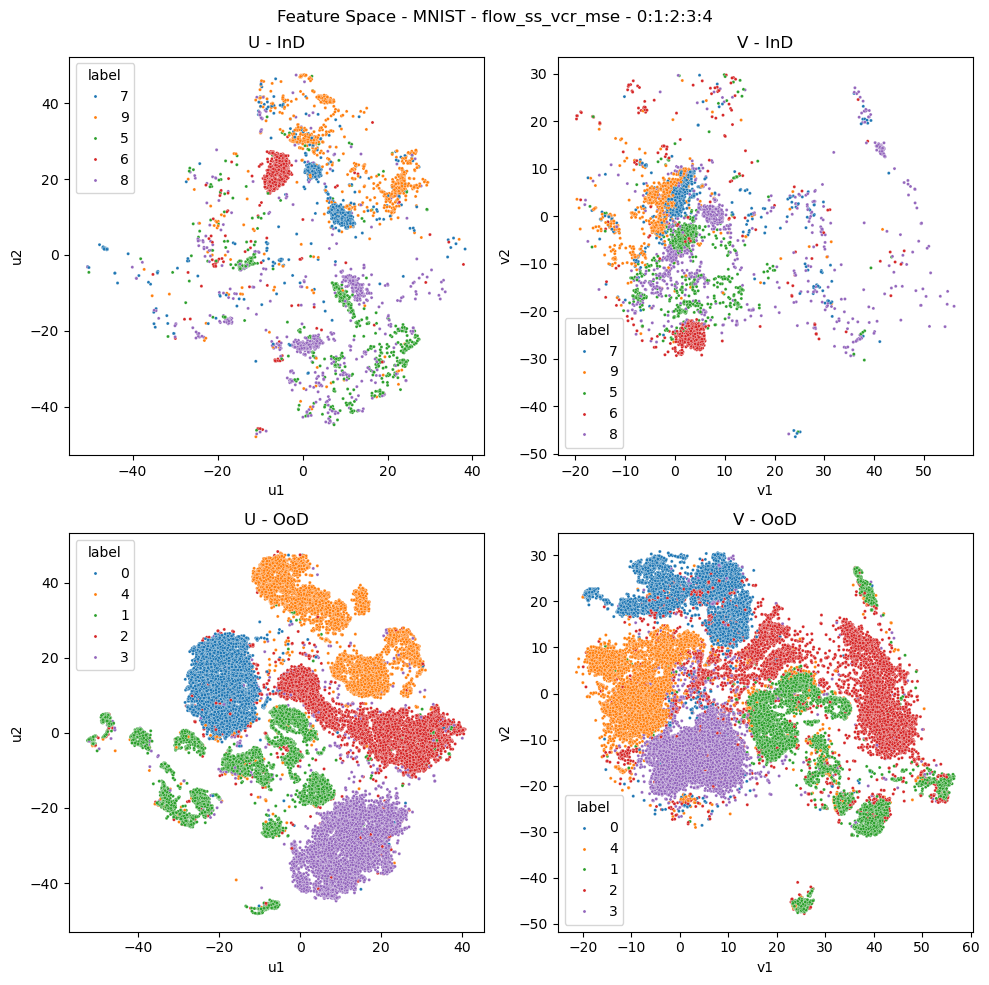

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:02,  1.07it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:02<00:01,  1.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:02<00:06,  2.24s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:04<00:04,  2.27s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:06<00:02,  2.31s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.40s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]

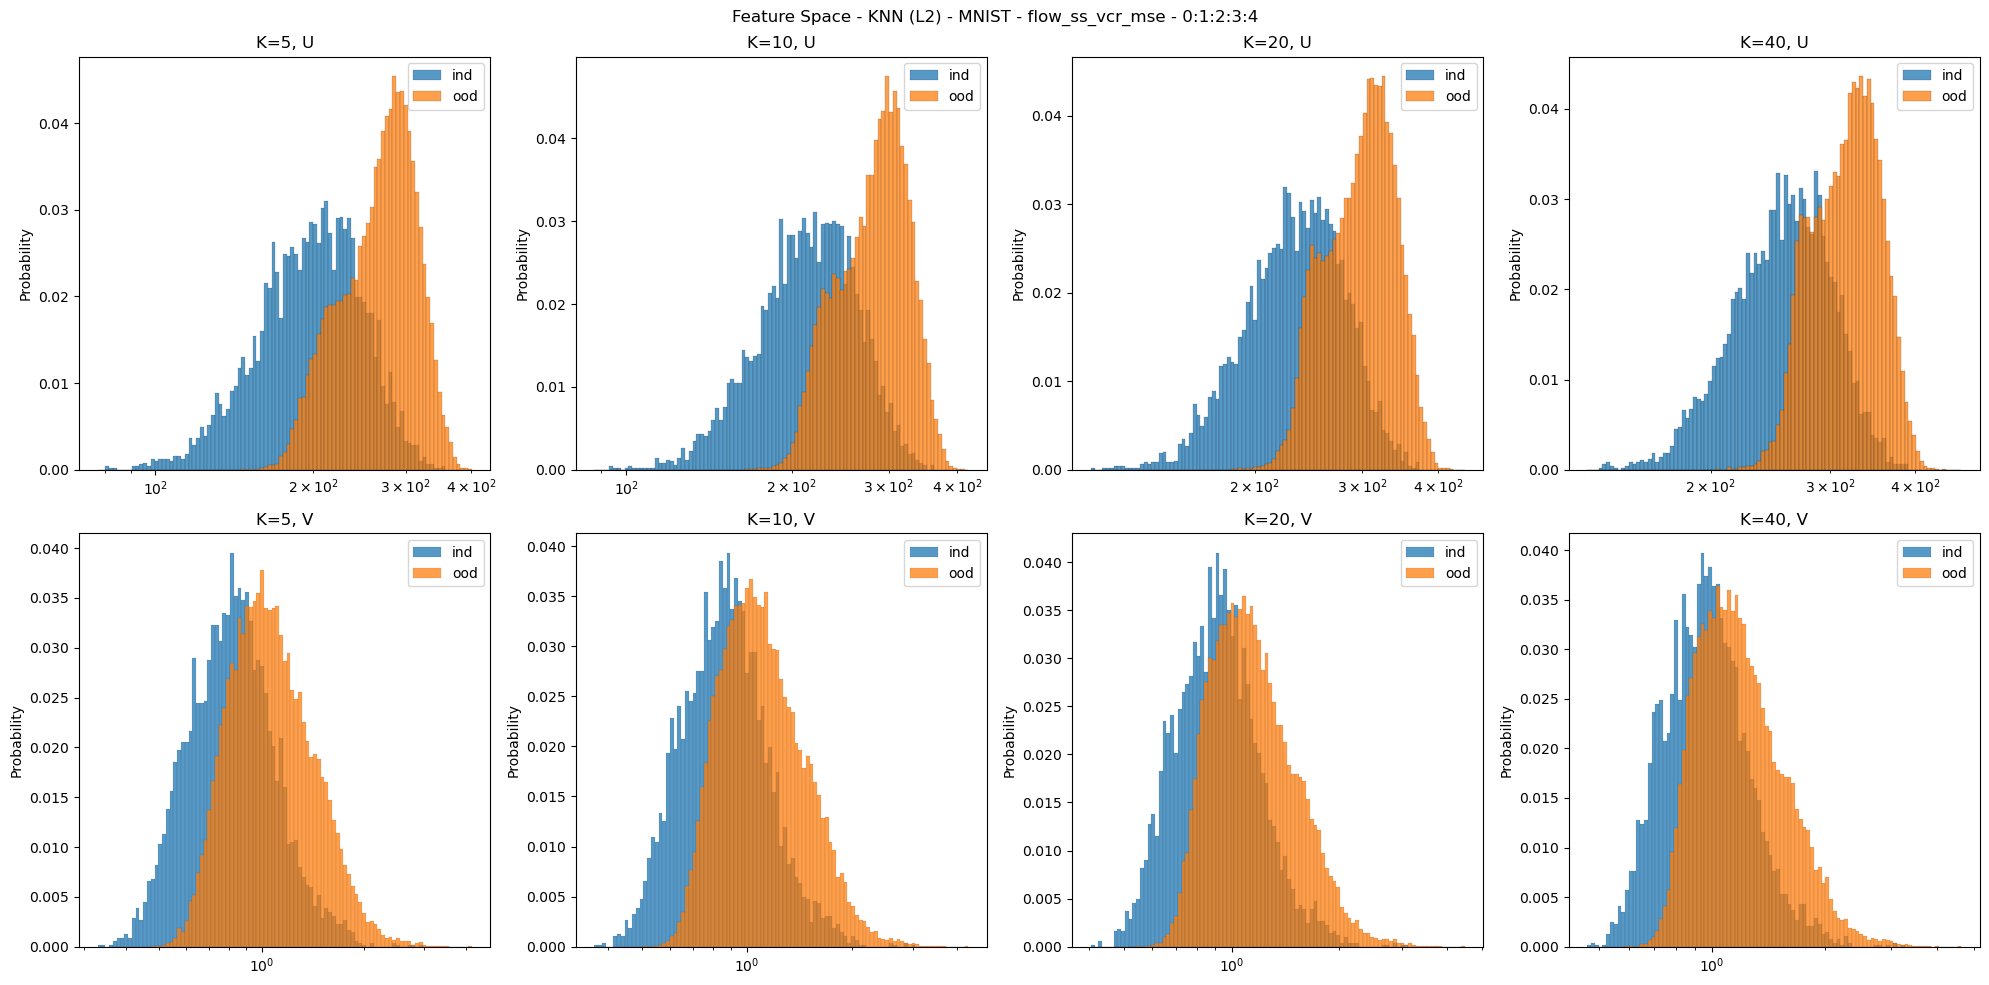

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:02,  1.08it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:02<00:00,  1.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.10s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.05s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:02<00:06,  2.21s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:04<00:04,  2.23s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:06<00:02,  2.27s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.47s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]

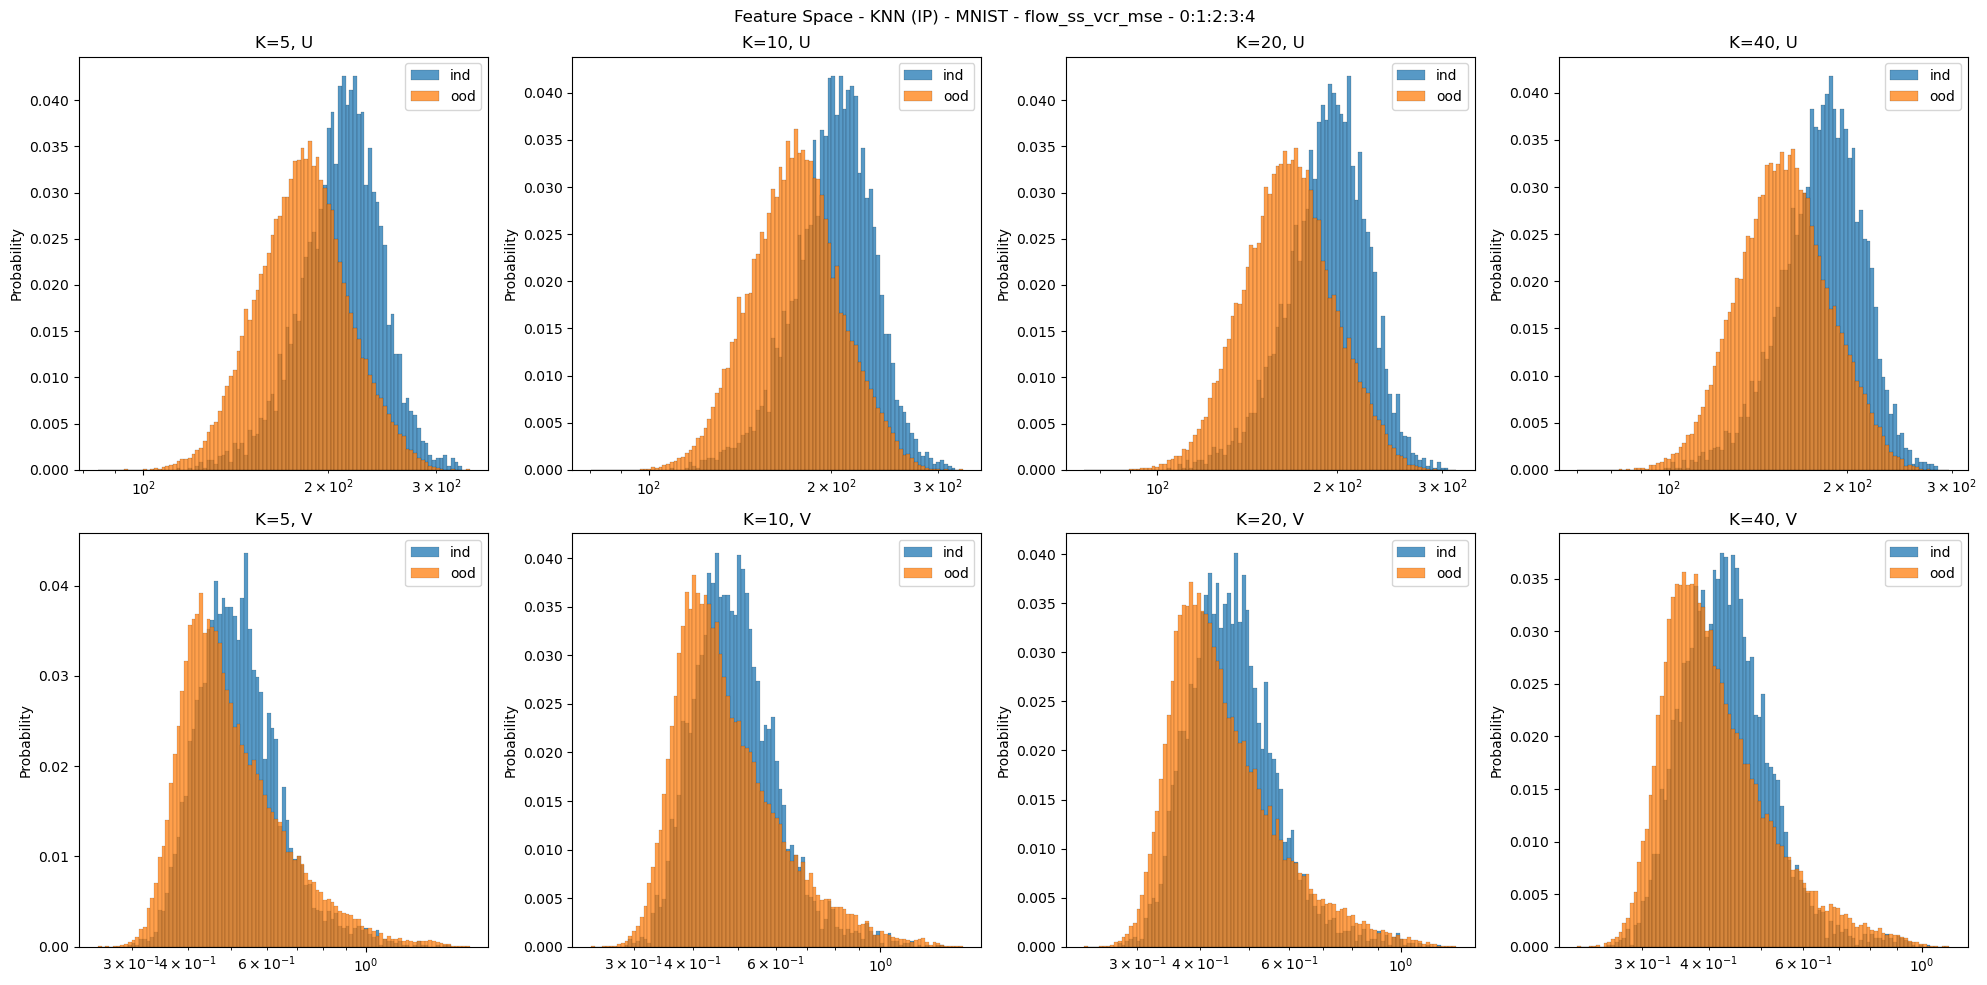

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

17.517273 0.80908763 0.9817234 0.13824126
17.476284 0.8007063 0.9829226 0.13787471
17.561852 0.8162596 0.97827727 0.13066499
17.734802 1.0313212 1.0529757 0.16761447
25.842558 1.2499185 24.836859 0.7448413


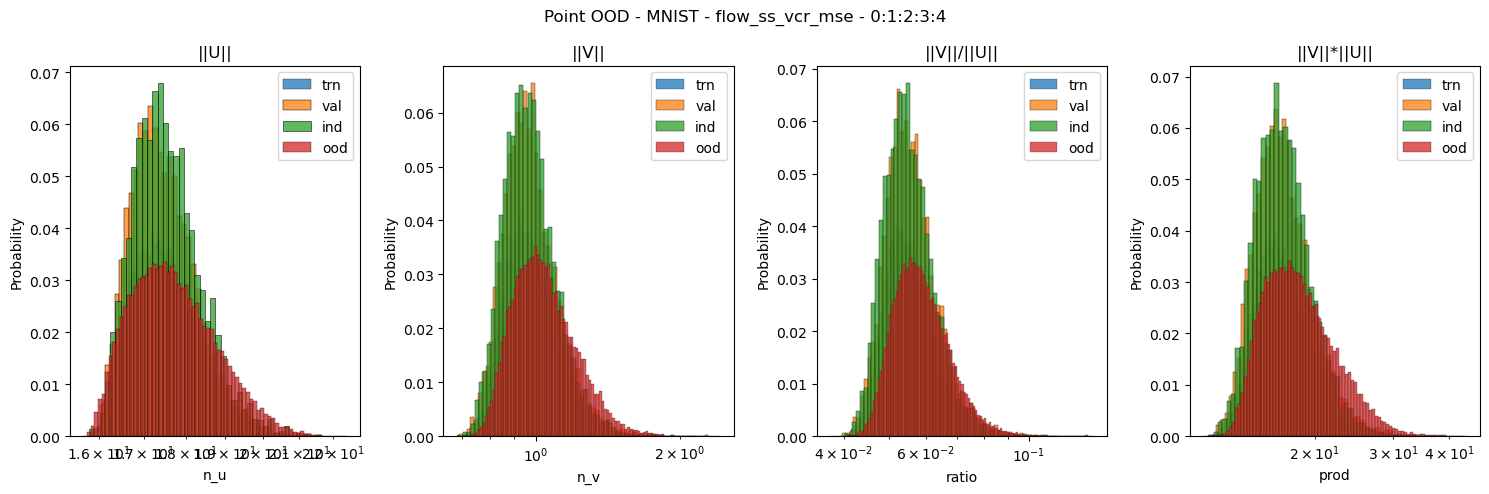

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


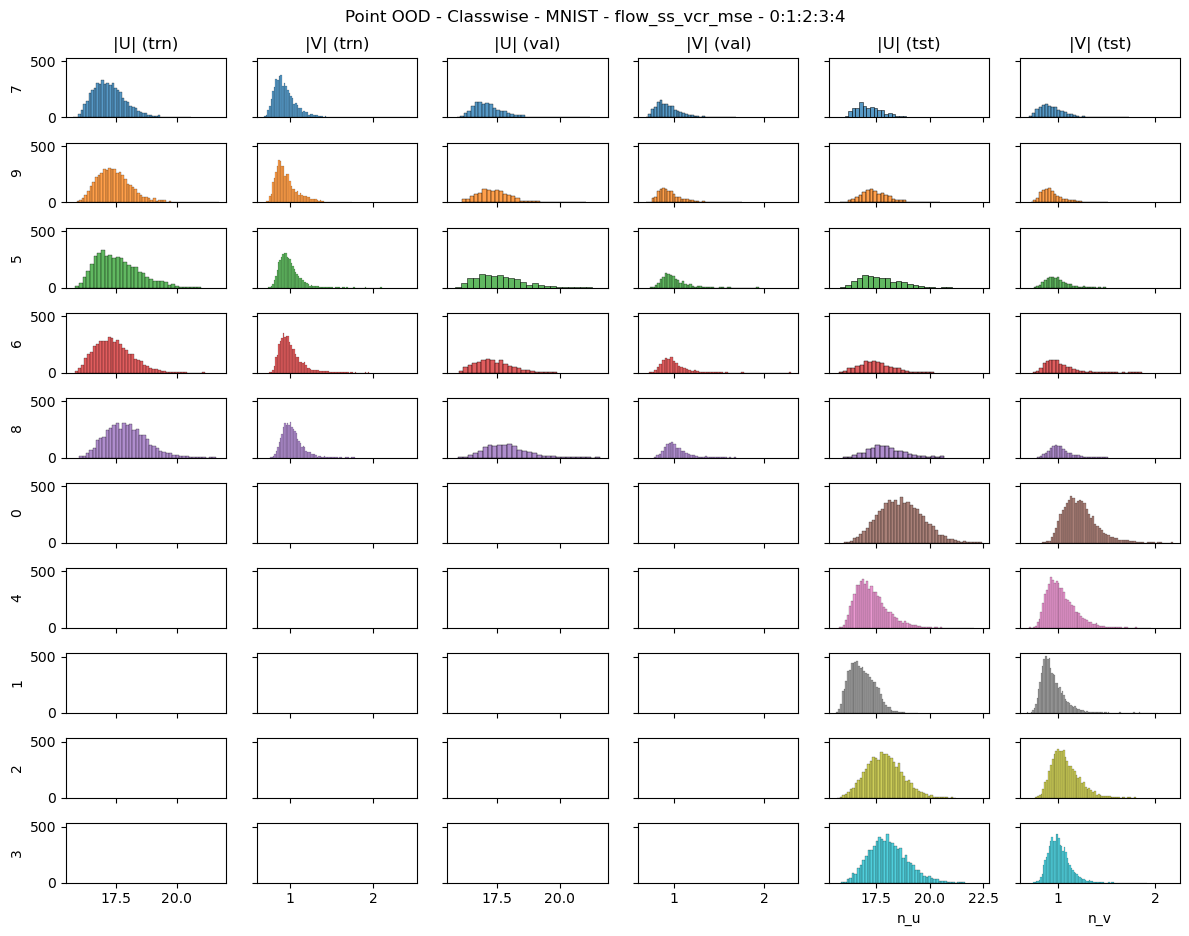

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

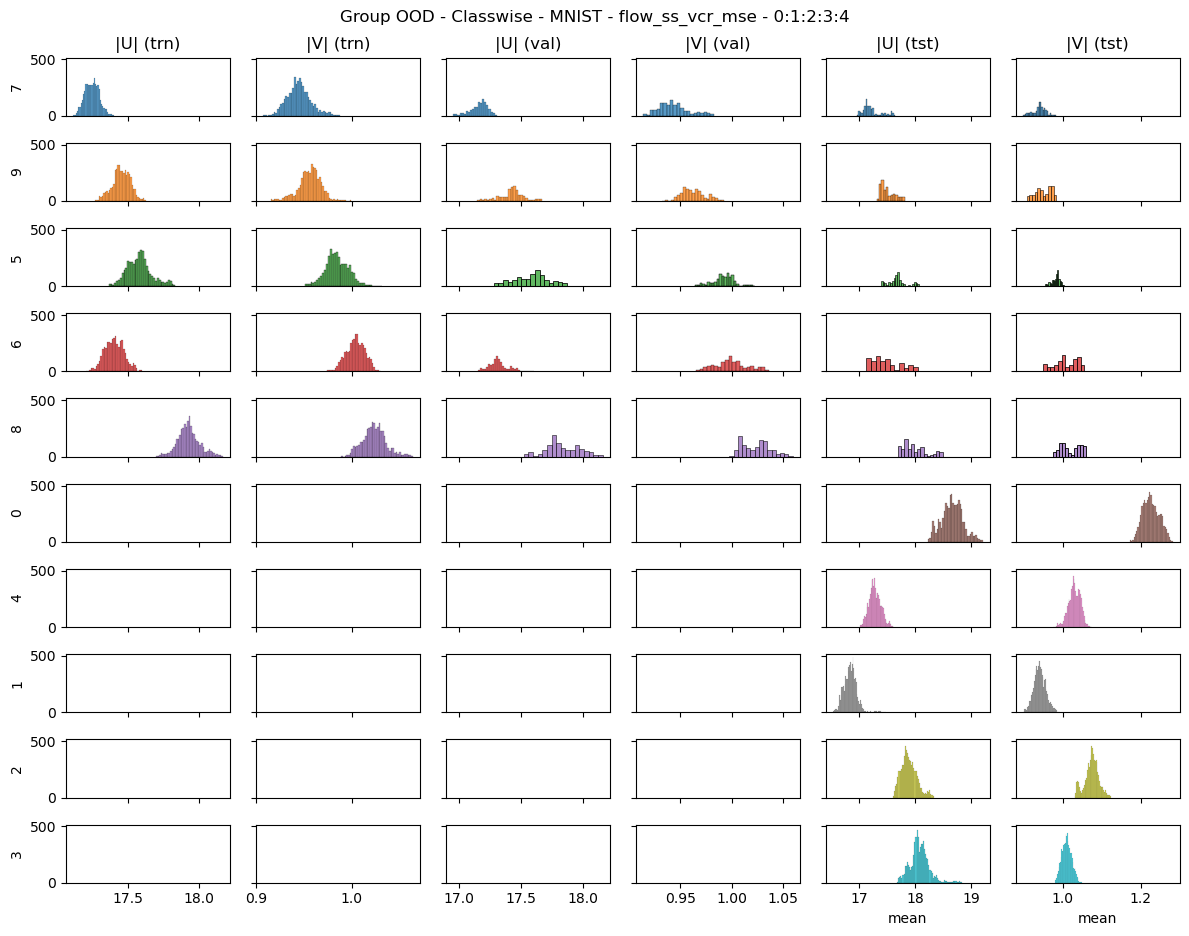

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()